# Results - Prelim. Spa-Temp Experiment

In this notebook, I will be walking through how we can estimate different methods based on the density cubes that we derive.

In [1]:
import sys, os
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

import pathlib

# standard python packages
import xarray as xr
import pandas as pd
import numpy as np

# Experiment Functions
from src.data.esdc import get_dataset
from src.features import Metrics
from src.features.temporal import select_period, get_smoke_test_time
from src.features.spatial import select_region, get_europe
from src.models.train_models import get_similarity_scores
from src.experiments.utils import dict_product, run_parallel_step

from src.features import Metrics
from src.features.density import get_density_cubes
from src.features.preprocessing import standardizer_data, get_reference_cube, get_common_indices
from src.models.similarity import cka_coefficient, rv_coefficient, rbig_it_measures

# # esdc tools
# from src.esdc.subset import select_pixel
# from src.esdc.shape import ShapeFileExtract, rasterize
# from esdc.transform import DensityCubes

from typing import List, Dict
import xarray as xr

from tqdm import tqdm

import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

## Results Plot

For this first set of results, I'm looking at the following:

* Entropy of the different spatial-temporal density cube compositions.
* MI between just the sames with not spatial-temporal features and the density cubes with different spatiel-temporal compositions.


**Hypothesis**

* Less mutual information with more features
* I'm not sure about entropy. 

In [29]:
RES_PATH = pathlib.Path(str(root)).joinpath("data/spa_temp/info_earth/entropy")
FIG_PATH = pathlib.Path(str(root)).joinpath("reports/figures/spa_temp/demos/infoearth/spain")

In [30]:
!ls $RES_PATH

v0_europe_rm_2002_2010.csv  v0_spain_precip_2002_2010.csv
v0_europe_rm_2010.csv	    v0_spain_precip_2010.csv
v0_spain_gpp_2002_2010.csv  v0_spain_rm_2002_2010.csv
v0_spain_gpp_2010.csv	    v0_spain_rm_2010.csv
v0_spain_lst_2002_2010.csv  v0_spain_sm_2002_2010.csv
v0_spain_lst_2010.csv	    v0_spain_sm_2010.csv


In [49]:
region = "spain"
period = "2002_2010"
variable = "gpp"
save_name = f"{region}_{variable}_{period}"

# read csv file
results_df = pd.read_csv(str(RES_PATH.joinpath(f'v0_{save_name}.csv')))
results_df['n_dimensions'][results_df['n_dimensions'] == 46] = 49
results_df.tail()

,Unnamed: 0,region,period,variable,spatial,temporal,n_dimensions,n_samples,entropy,time
19,0,spain,2002_2010,gross_primary_productivity,5,2,49,234171,-37.922326,698.914138
20,0,spain,2002_2010,gross_primary_productivity,4,3,49,264092,-47.388406,654.039219
21,0,spain,2002_2010,gross_primary_productivity,3,5,49,295200,-50.494578,532.870852
22,0,spain,2002_2010,gross_primary_productivity,2,12,49,325221,-54.424904,942.497124
23,0,spain,2002_2010,gross_primary_productivity,1,46,49,331731,-18.420635,1279.659309


## Entropy

In [50]:
from typing import Optional

def plot_entropies(df, save_name: Optional[str]=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    sns.lineplot(x='ratio', y='entropy_norm', hue='n_dimensions', data=df, ax=ax, marker='.', markersize=20, palette='cubehelix_r')
    ax.set(
        xlabel='Spatial / Temporal Ratio',
        ylabel='Entropy',
        xscale='log',
    )
    plt.tight_layout()
    if save_name:
        fig.savefig(FIG_PATH.joinpath(f"H_{save_name}.png"))

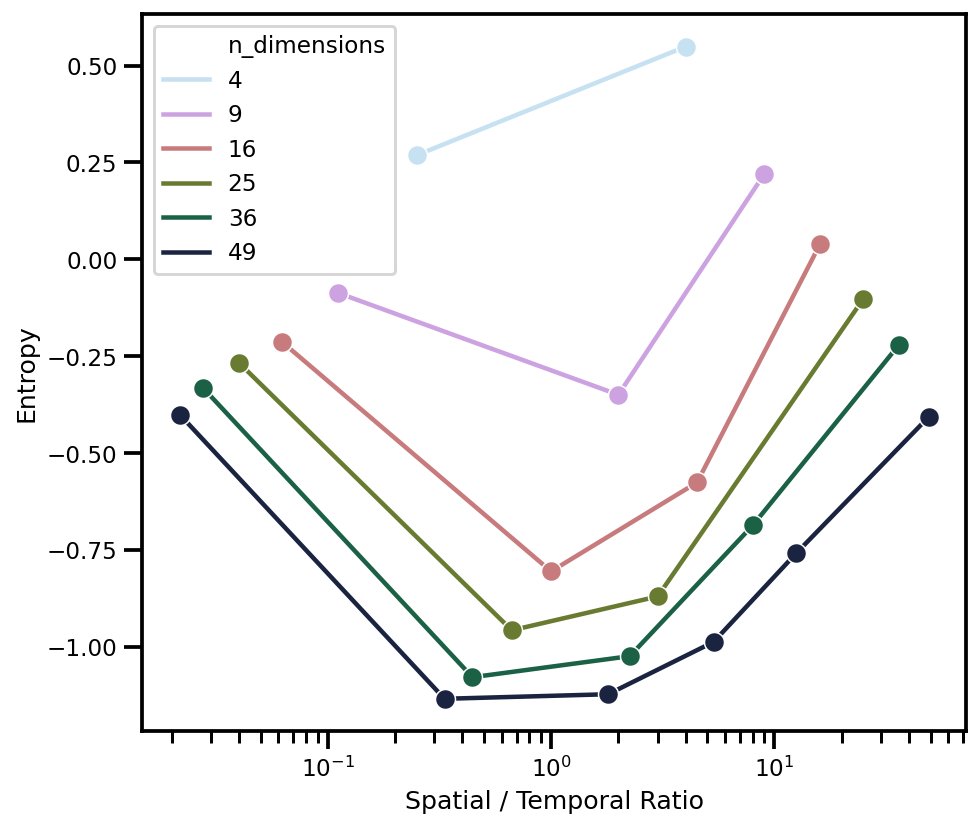

In [51]:
sub_df = results_df.copy()

sub_df['ratio'] = sub_df['spatial']**2 / sub_df['temporal']
sub_df['entropy_norm'] = sub_df['entropy'] / (sub_df["spatial"] ** 2 * sub_df["temporal"]) 
# sub_df['dimensions'] = sub_df['spatial'] ** 2 + sub_df['temporal']

# sub_df['nH'] = (sub_df['rbig_H_y'] /  sub_df['dimensions']) #* np.log(2)
sub_df["spatial"] = sub_df["spatial"].astype('category')
sub_df["temporal"] = sub_df["temporal"].astype('category')
sub_df["n_dimensions"] = sub_df["n_dimensions"].astype('category')

plot_entropies(sub_df, save_name)

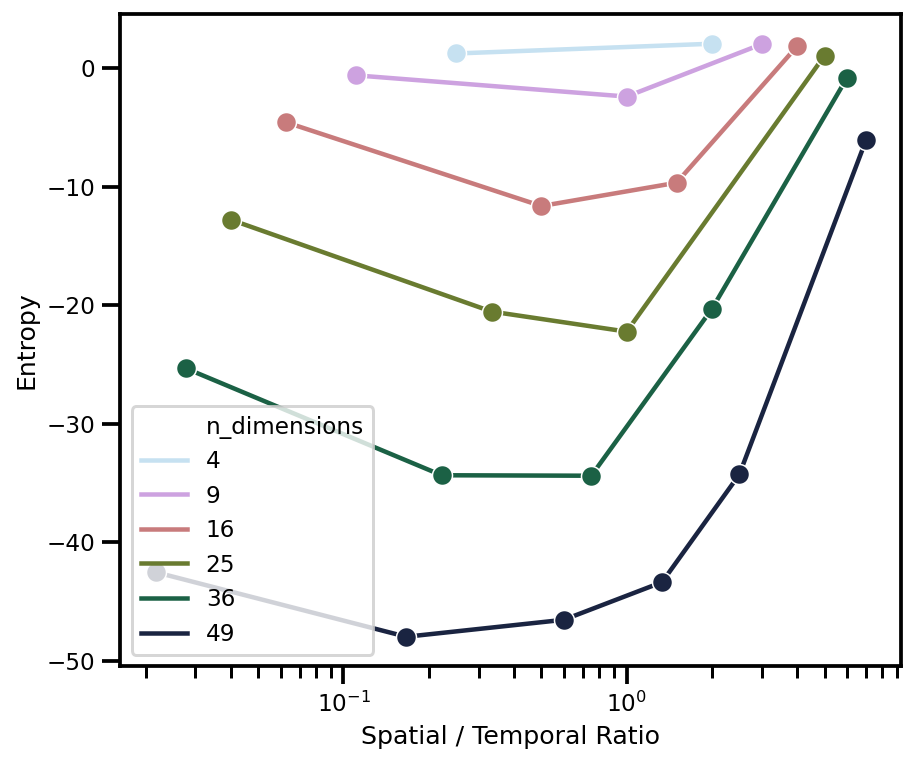

In [18]:


fig, ax = plt.subplots(figsize=(7, 6))

sns.lineplot(x='ratio', y='entropy', hue='n_dimensions', data=sub_df, ax=ax, marker='.', markersize=20, palette='cubehelix_r')
ax.set(
    xlabel='Spatial / Temporal Ratio',
    ylabel='Entropy',
    xscale='log',
)
# sns.scatterplot(x='ratio', y='rv_coeff', data=sub_df, ax=ax, label='RV')
# ax[0].set(xscale='log'), ax[1].set_xscale('log')
# ax[0].set_xlabel('Spatial / Temporal Ratio'), ax[1].set_xlabel('Spatial / Temporal Ratio')
# ax[0].set_ylabel('Entropy'), ax[1].set_ylabel('')

plt.show()

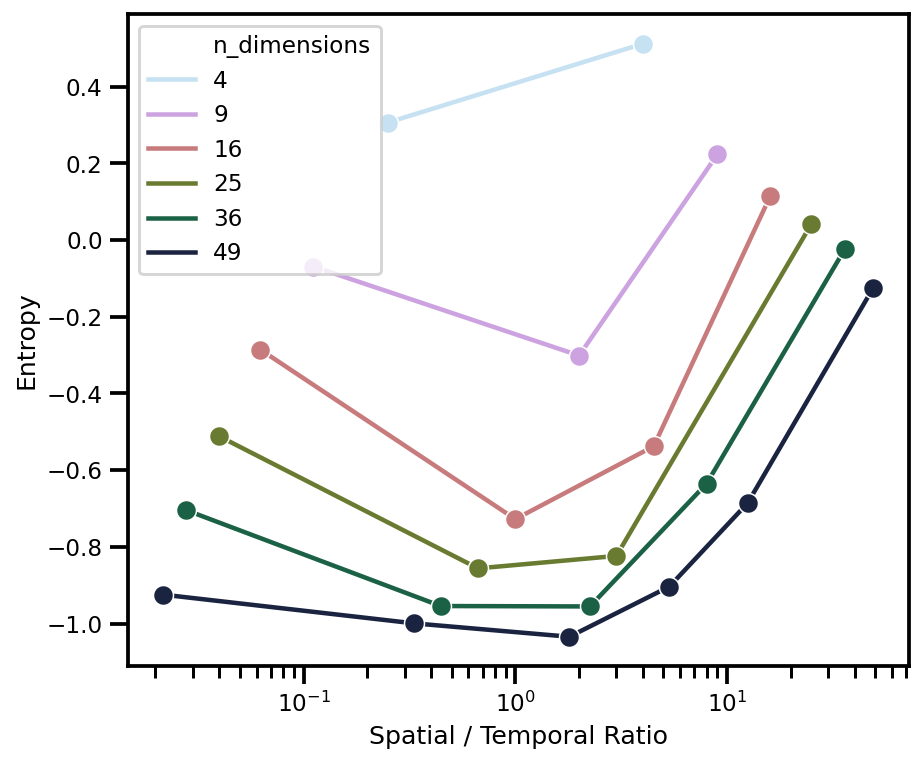

In [19]:
sub_df = results_df.copy()

sub_df['ratio'] = sub_df['spatial']**2 / sub_df['temporal']
sub_df['entropy_norm'] = sub_df['entropy'] / (sub_df["spatial"] ** 2 * sub_df["temporal"]) 
# sub_df['dimensions'] = sub_df['spatial'] ** 2 + sub_df['temporal']

# sub_df['nH'] = (sub_df['rbig_H_y'] /  sub_df['dimensions']) #* np.log(2)
sub_df["spatial"] = sub_df["spatial"].astype('category')
sub_df["temporal"] = sub_df["temporal"].astype('category')
sub_df["n_dimensions"] = sub_df["n_dimensions"].astype('category')

fig, ax = plt.subplots(figsize=(7, 6))

sns.lineplot(x='ratio', y='entropy_norm', hue='n_dimensions', data=sub_df, ax=ax, marker='.', markersize=20, palette='cubehelix_r')
ax.set(
    xlabel='Spatial / Temporal Ratio',
    ylabel='Entropy',
    xscale='log',
)
# sns.scatterplot(x='ratio', y='rv_coeff', data=sub_df, ax=ax, label='RV')
# ax[0].set(xscale='log'), ax[1].set_xscale('log')
# ax[0].set_xlabel('Spatial / Temporal Ratio'), ax[1].set_xlabel('Spatial / Temporal Ratio')
# ax[0].set_ylabel('Entropy'), ax[1].set_ylabel('')

plt.show()

So we see that the configuration with more features has less entropy?

### Normalized Entropy


#### Normalization by Features

So firstly, we can normalize by the features. This will allow us to see a more relative impact on the entropy measures. We know there will be a change in entropy with more features, but it would be nice to see the relative impact. So we can do this by dividing by the number of features.

$$
\tilde{\text{H}}(X) = \frac{1}{\text{n_features}}H(X)
$$